----------------------------------------------------------
PENELITIAN: ANOMALY DETECTION WITH RANDOM FOREST (RT_IOT2022.csv)
----------------------------------------------------------

[FASE I: PREPROCESSING DIMULAI]
1. Data berhasil dimuat. Total Baris Awal: 123117, Kolom: 85
2. Duplikat dihapus: 99278 baris.
   Baris setelah cleaning: 23839. Total NaN: 0
3. Encoding dan Pemisahan Fitur/Target...
   Jumlah fitur (X) setelah One-Hot Encoding: 91
4. Scaling Data dan Splitting (80% Train, 20% Test)...
   Data Training (80%): 19071 sampel
   Data Testing (20%): 4768 sampel

[FASE I: PREPROCESSING SELESAI]

[FASE II: PEMODELAN DIMULAI]
5. Model Random Forest terlatih dalam waktu: 5.37 detik.

[FASE III: EVALUASI DIMULAI]
7. Hasil Metrik Kinerja:
   Akurasi (Accuracy): 0.9874
   Presisi (Precision): 0.9873
   Recall: 0.9874
   F1-Score: 0.9873

--- Classification Report (Per Kelas) ---
                            precision    recall  f1-score   support

            ARP_poisioning       0.97

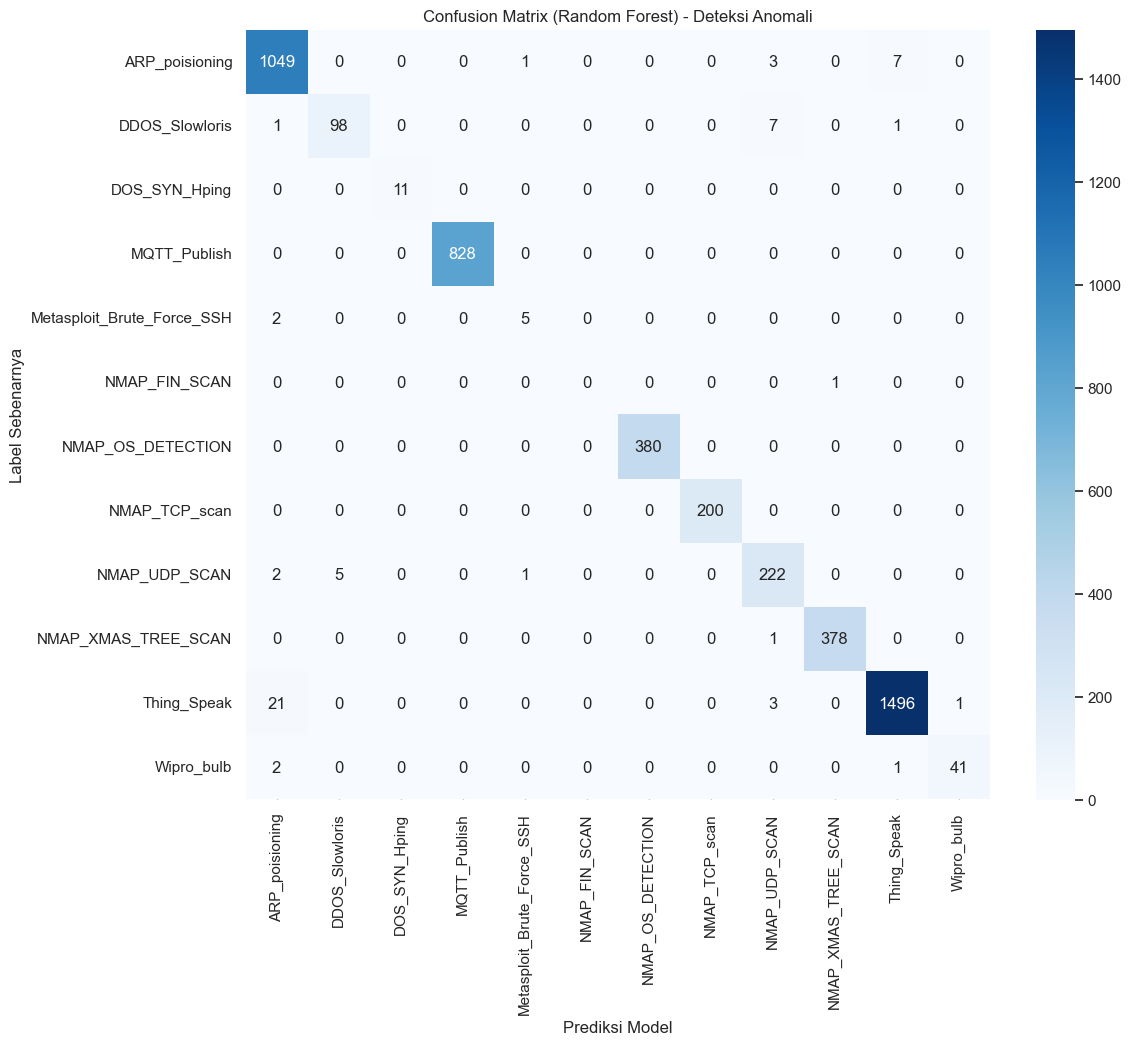


[FASE III: EVALUASI SELESAI]

[FASE IV: INTERPRETASI DIMULAI]
9. Menganalisis 10 Fitur Paling Berpengaruh...

--- 10 Fitur Paling Berpengaruh (Feature Importance) ---
flow_iat.min            0.052290
fwd_PSH_flag_count      0.038006
fwd_pkts_payload.avg    0.037318
fwd_iat.min             0.036073
fwd_URG_flag_count      0.033645
service_mqtt            0.031816
bwd_pkts_payload.avg    0.029194
bwd_subflow_bytes       0.028611
bwd_pkts_payload.tot    0.028581
active.min              0.026751
dtype: float64


C:\Users\aisyah widodo\AppData\Local\Temp\ipykernel_4364\1530102243.py:184: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_10_features.values, y=top_10_features.index, palette='viridis')


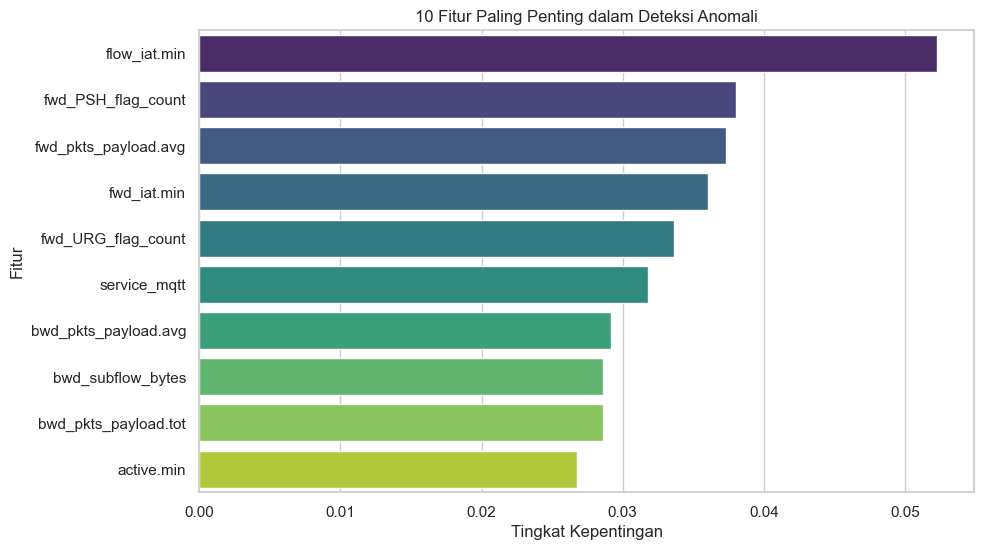


[FASE IV: INTERPRETASI SELESAI]

[FASE V: DOKUMENTASI DAN REFLEKSI]
Semua Tahap implementasi telah selesai. Harap gunakan output konsol dan 2 grafik di atas untuk mengisi Bab IV Laporan Anda.


In [2]:
# FASE 0: PERSIAPAN AWAL
# Import semua library yang diperlukan
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Konfigurasi visualisasi
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
pd.set_option('display.max_columns', None)

# Definisi nama file
DATA_FILE = 'RT_IOT2022.csv'
print("----------------------------------------------------------")
print(f"PENELITIAN: ANOMALY DETECTION WITH RANDOM FOREST ({DATA_FILE})")
print("----------------------------------------------------------")

# ==============================================================================
# FASE I: PREPROCESSING (PEMBERSIHAN DAN PENYIAPAN DATA)
# ==============================================================================
print("\n[FASE I: PREPROCESSING DIMULAI]")

# 1. PEMUATAN DATA
try:
    df = pd.read_csv(DATA_FILE)
    print(f"1. Data berhasil dimuat. Total Baris Awal: {df.shape[0]}, Kolom: {df.shape[1]}")
    
    # Identifikasi kolom target secara dinamis (biasanya kolom terakhir)
    TARGET_COL = df.columns[-1]
    
except FileNotFoundError:
    print(f"ERROR: File '{DATA_FILE}' tidak ditemukan.")
    exit()

# 2. DATA CLEANING & PENGHAPUSAN KOLOM TIDAK RELEVAN
# Hapus kolom indeks yang tidak relevan (termasuk yang tidak bernama)
if df.columns[0].startswith('Unnamed'):
    df = df.drop(columns=[df.columns[0]], axis=1)
if 'id.orig_p' in df.columns:
    df = df.drop(columns=['id.orig_p'], axis=1) # Menghapus Port Asal, mempertahankan Port Tujuan (id.resp_p)

# Menangani nilai duplikat
initial_rows = df.shape[0]
df = df.drop_duplicates()
print(f"2. Duplikat dihapus: {initial_rows - df.shape[0]} baris.")

# Menangani nilai Infinity ('inf') dan NaN (Not a Number)
df = df.replace([np.inf, -np.inf], np.nan)

# Menangani Missing Values (NaN)
for col in df.columns:
    if df[col].dtype != object and df[col].isnull().any():
        # Imputasi Mean untuk kolom numerik
        df[col].fillna(df[col].mean(), inplace=True)
    elif df[col].dtype == object and df[col].isnull().any():
        # Imputasi Mode untuk kolom kategorikal
        df[col].fillna(df[col].mode()[0], inplace=True)

print(f"   Baris setelah cleaning: {df.shape[0]}. Total NaN: {df.isnull().sum().sum()}")


# 3. FEATURE ENGINEERING DAN ENCODING
print("3. Encoding dan Pemisahan Fitur/Target...")

# Identifikasi kolom kategorikal
categorical_features = df.select_dtypes(include='object').columns.tolist()

# Kolom Target sudah diidentifikasi sebagai TARGET_COL
if TARGET_COL in categorical_features:
    categorical_features.remove(TARGET_COL)

# 3.1. Label Encoding (Target Column)
le = LabelEncoder()
df['Target_Encoded'] = le.fit_transform(df[TARGET_COL])
y = df['Target_Encoded'] # Label numerik
CLASS_NAMES = le.classes_ # Simpan nama-nama kelas asli

# 3.2. One-Hot Encoding (Fitur Kategorikal)
X = df.drop(columns=[TARGET_COL, 'Target_Encoded'])
X = pd.get_dummies(X, columns=categorical_features, drop_first=True)
print(f"   Jumlah fitur (X) setelah One-Hot Encoding: {X.shape[1]}")


# 4. SCALING DATA DAN SPLITTING (Pembagian Data)
print("4. Scaling Data dan Splitting (80% Train, 20% Test)...")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

# Pembagian Data (Split) - Strategi Stratified untuk menjaga proporsi kelas
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled_df, y, test_size=0.2, random_state=42, stratify=y
)

print(f"   Data Training (80%): {X_train.shape[0]} sampel")
print(f"   Data Testing (20%): {X_test.shape[0]} sampel")

print("\n[FASE I: PREPROCESSING SELESAI]")


# ==============================================================================
# FASE II & III: PEMODELAN RANDOM FOREST & EVALUASI
# ==============================================================================
print("\n[FASE II: PEMODELAN DIMULAI]")

# 5. PEMODELAN RANDOM FOREST
N_ESTIMATORS = 100
MAX_DEPTH = 20 # Sesuai rekomendasi dari proposal (15-25)

rf_model = RandomForestClassifier(
    n_estimators=N_ESTIMATORS, 
    max_depth=MAX_DEPTH,
    random_state=42, 
    n_jobs=-1 # Menggunakan semua core CPU untuk pelatihan cepat
)

start_time = time.time()
rf_model.fit(X_train, y_train)
end_time = time.time()

training_time = end_time - start_time
print(f"5. Model Random Forest terlatih dalam waktu: {training_time:.2f} detik.")

# 6. PENGUJIAN DAN PREDIKSI
print("\n[FASE III: EVALUASI DIMULAI]")
y_pred = rf_model.predict(X_test)


# 7. ANALISIS METRIK KINERJA
print("7. Hasil Metrik Kinerja:")

# Hitung metrik
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

print(f"   Akurasi (Accuracy): {accuracy:.4f}")
print(f"   Presisi (Precision): {precision:.4f}")
print(f"   Recall: {recall:.4f}")
print(f"   F1-Score: {f1:.4f}")

# Classification Report (Detail per kelas)
print("\n--- Classification Report (Per Kelas) ---")
print(classification_report(y_test, y_pred, target_names=CLASS_NAMES, zero_division=0))


# 8. VISUALISASI CONFUSION MATRIX
print("\n8. Visualisasi Confusion Matrix...")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.title('Confusion Matrix (Random Forest) - Deteksi Anomali')
plt.ylabel('Label Sebenarnya')
plt.xlabel('Prediksi Model')
plt.show()

print("\n[FASE III: EVALUASI SELESAI]")


# ==============================================================================
# FASE IV: INTERPRETASI (FEATURE IMPORTANCE)
# ==============================================================================
print("\n[FASE IV: INTERPRETASI DIMULAI]")

# 9. ANALISIS FEATURE IMPORTANCE
print("9. Menganalisis 10 Fitur Paling Berpengaruh...")
feature_importances = pd.Series(rf_model.feature_importances_, index=X_scaled_df.columns)
top_10_features = feature_importances.nlargest(10)

print("\n--- 10 Fitur Paling Berpengaruh (Feature Importance) ---")
print(top_10_features)

# Visualisasi Feature Importance
plt.figure(figsize=(10, 6))
sns.barplot(x=top_10_features.values, y=top_10_features.index, palette='viridis')
plt.title('10 Fitur Paling Penting dalam Deteksi Anomali')
plt.xlabel('Tingkat Kepentingan')
plt.ylabel('Fitur')
plt.show()

print("\n[FASE IV: INTERPRETASI SELESAI]")

# ==============================================================================
# FASE V: DOKUMENTASI DAN REFLEKSI
# ==============================================================================
print("\n[FASE V: DOKUMENTASI DAN REFLEKSI]")
print("Semua Tahap implementasi telah selesai. Harap gunakan output konsol dan 2 grafik di atas untuk mengisi Bab IV Laporan Anda.")